In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ttest_ind

In [117]:
test = pd.read_csv('test.csv', header=None)
train_target = pd.read_csv('train-target.csv', header=None)
train = pd.read_csv('train.csv', header=None)
sample_submission = pd.read_csv('sample-submission.csv', header=None)

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
y_train = train_target

In [98]:
def make_submission(data, name):
    pd.DataFrame(data[:, 1]).to_csv(name, index=False, header=None)

## ROC-AUC on val. is 1, on test is 0.506, really strange

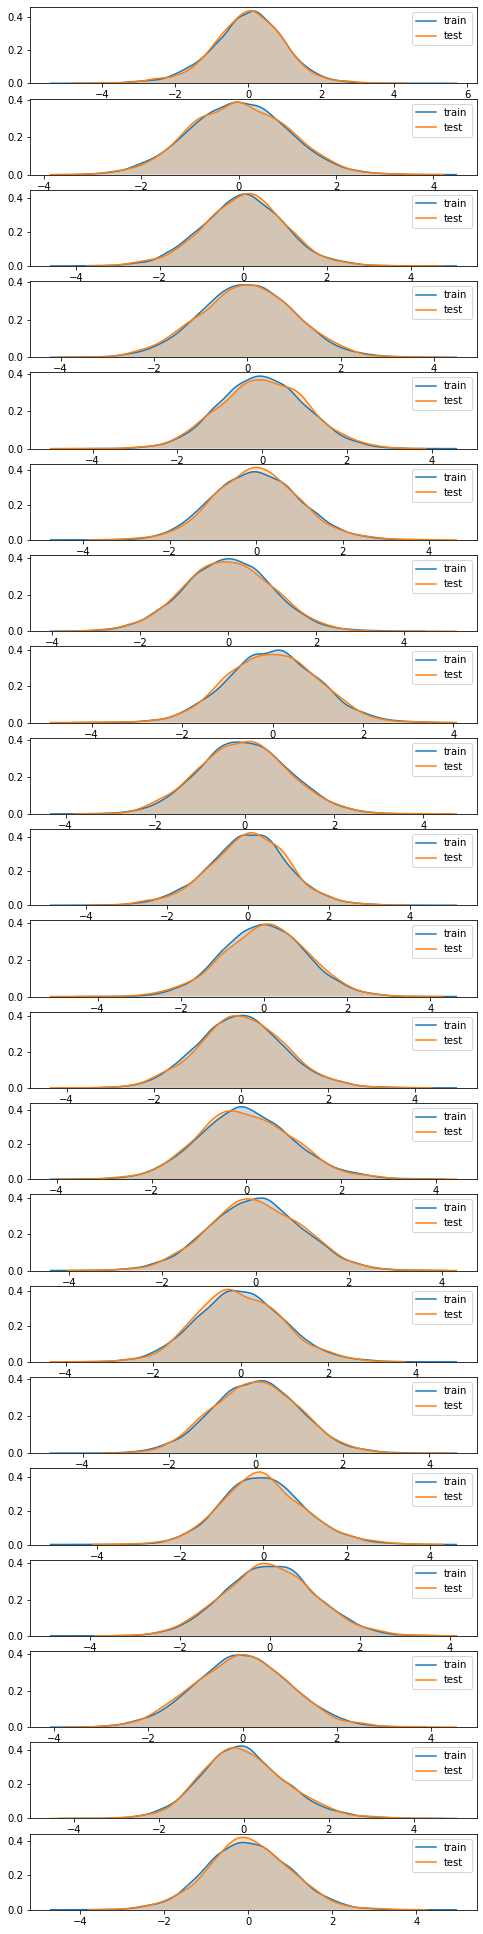

In [108]:
num_features = 21
fig, axs = plt.subplots(num_features, figsize=(8, 35))
for i in range(num_features):
    sns.kdeplot(X_train[:, i], ax=axs[i], shade=True, label='train')
    sns.kdeplot(X_test[:, i], ax=axs[i], shade=True, label='test')
plt.legend()

## The data is different for test and train

In [118]:
good_features = []
bad_features = []
alpha = 0.15
for i in range(X_train.shape[1]):
    stat, p = ttest_ind(X_train[:, i], X_test[:, i])
    common = True if p > alpha else False
    if common:
        good_features.append(i)
    else:
        bad_features.append(i)

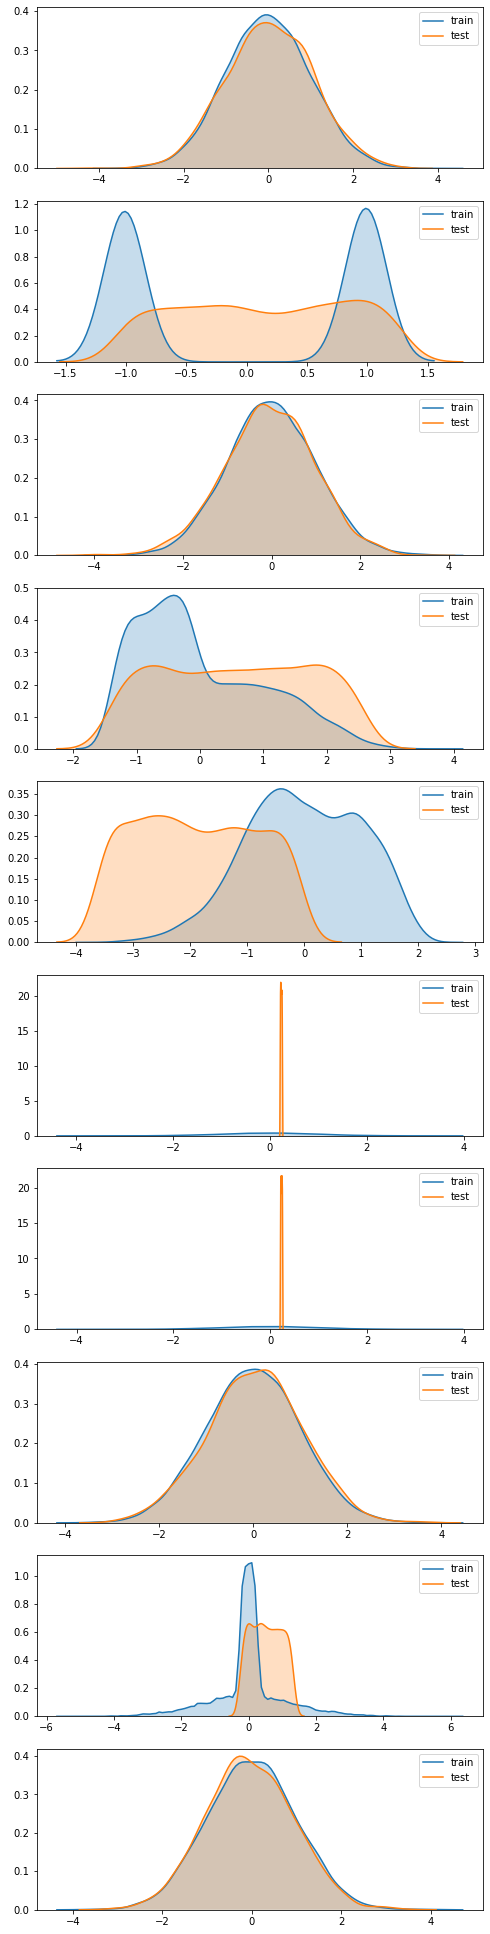

In [15]:
num_features = len(bad_features)
fig, axs = plt.subplots(num_features, figsize=(8, 35))
for i, feat in enumerate(bad_features):
    sns.kdeplot(X_train[:, feat], ax=axs[i], shade=True, label='train')
    sns.kdeplot(X_test[:, feat], ax=axs[i], shade=True, label='test')
plt.legend()

In [119]:
train.drop(bad_features, axis=1, inplace=True)
test.drop(bad_features, axis=1, inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
y_train = train_target

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
y_train = y_train.values.reshape(1, -1)[0]

Random Forest with alpha = 0.05 is 0.818 ROC
alpha = 0.1 is 0.827; 0.15 = 0.831

In [128]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_val)
roc_auc_score(y_val, y_pred[:, 1])

0.8143031153993854

In [ ]:
y_test = rfc.predict_proba(X_test)
make_submission(y_test, 'random_all_data.csv')

In [179]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(tol=0.1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_val)
roc_auc_score(y_val, y_pred[:, 1])

0.6355806771633384

In [43]:
from sklearn.neighbors import KNeighborsClassifier

rocs = []
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict_proba(X_val)
    rocs.append(roc_auc_score(y_val, y_pred[:, 1]))

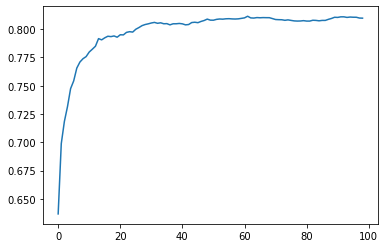

In [44]:
plt.plot(rocs);

In [132]:
knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(X_train, y_train)
y_pred = knn.predict_proba(X_val)
roc_auc_score(y_val, y_pred[:, 1])

0.7937763016833077

In [47]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [133]:
params = {
    'max_depth': [11],
    'colsample_bytree': [0.6],
    'gamma': [0.6],
    'alpha': [0.45],
    'subsample': [1],
    'n_estimators': [20], 
    'learning_rate': [0.05],
    'n_jobs': [-1]
}

xgb_search_cv = GridSearchCV(xgb.XGBClassifier(), params, scoring='roc_auc', n_jobs=-1)
xgb_search_cv.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [134]:
xgb_search_cv.best_score_, xgb_search_cv.best_params_

(0.7983095645883994,
 {'alpha': 0.45,
  'colsample_bytree': 0.6,
  'gamma': 0.6,
  'learning_rate': 0.05,
  'max_depth': 11,
  'n_estimators': 20,
  'n_jobs': -1,
  'subsample': 1})

In [47]:
y_pred = xgb_search_cv.best_estimator_.predict_proba(X_test)
make_submission(y_pred, 'xgboost tuned.csv')

In [50]:
from sklearn.linear_model import SGDClassifier

sgd_class = SGDClassifier(loss='log', alpha=0.01, penalty='l1')
sgd_class.fit(X_train, y_train)
y_pred = sgd_class.predict_proba(X_val)
roc_auc_score(y_val, y_pred[:, 1])

0.5948556531350241

In [51]:
def test_estimator(estimator):
    est = estimator
    est.fit(X_train, y_train)
    print(roc_auc_score(y_val, est.predict_proba(X_val)[:, 1]))

In [137]:
from sklearn.svm import SVC

test_estimator(SVC(probability=True))

0.8143971214157706


In [62]:
SVM = SVC(probability=True)
SVM.fit(X_train, y_train)
y_pred_SVM = SVM.predict_proba(X_val)[:, 1]
y_pred_ranfor = rfc.predict_proba(X_val)[:, 1]
roc_auc = []
for i in range(101):
    y_pred_temp = y_pred_SVM*(i/100) + y_pred_ranfor*(100-i)/100
    score = roc_auc_score(y_val, y_pred_temp)
    roc_auc.append(score)

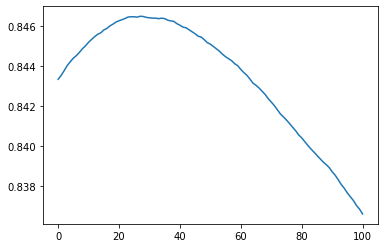

In [63]:
plt.plot(roc_auc)

In [59]:
i_optim = np.argmax(roc_auc)

In [67]:
y_train = y_train.values.reshape(1, -1)[0]

In [86]:
def make_submission(data, name):
    pd.DataFrame(data).to_csv(name, index=False, header=None)

In [71]:
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, y_train)

SVM = SVC(probability=True)
SVM.fit(X_train, y_train)

y_pred_SVM = SVM.predict_proba(X_test)[:, 1]
y_pred_ranfor = rfc.predict_proba(X_test)[:, 1]

y_pred_final = y_pred_SVM*(i_optim/100) + y_pred_ranfor*(100-i_optim)/100

In [87]:
make_submission(y_pred_final, 'forest_svm.csv')

In [77]:
sample_submission

,0
0,0.548814
1,0.715189
2,0.602763
3,0.544883
4,0.423655
...,...
1995,0.791282
1996,0.721198
1997,0.480108
1998,0.643864


In [88]:
a = pd.read_csv('forest_svm.csv')
a

,0.17687412363304184
0,0.295150
1,0.447893
2,0.422110
3,0.300698
4,0.311520
...,...
1994,0.285526
1995,0.392093
1996,0.214988
1997,0.270468


In [81]:
b = pd.read_csv('random_all_data.csv')
b

,0.5
0,0.2
1,0.4
2,0.5
3,0.2
4,0.4
...,...
1994,0.3
1995,0.4
1996,0.1
1997,0.1


голый 0.824191
C=0.5 0.820
kernel poly 0.65
'rpf' degree=4 0.82418
degree=2 

In [138]:
from sklearn.naive_bayes import GaussianNB
test_estimator(GaussianNB(binarize=0.5))

TypeError: __init__() got an unexpected keyword argument 'binarize'

In [142]:
from sklearn.naive_bayes import BernoulliNB
test_estimator(BernoulliNB(binarize=3))

0.5054063460061444


In [161]:
from sklearn.tree import DecisionTreeClassifier
test_estimator(DecisionTreeClassifier(max_depth=8, min_samples_leaf=1))

0.7002043130760368


In [100]:
est = SVC(probability=True)
est.fit(X_train, y_train)
y_pred = est.predict_proba(X_test)
make_submission(y_pred, 'SVM.csv')

C:\Users\anana\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [71]:
y_pred

array([[0.91451891, 0.08548109],
       [0.91343792, 0.08656208],
       [0.88299123, 0.11700877],
       ...,
       [0.44212516, 0.55787484],
       [0.90329023, 0.09670977],
       [0.5166915 , 0.4833085 ]])

In [325]:
y = 0.818911275645103
result = 100 if y > 0.82 else (40 + (y - 0.6) / 0.22 * 60 if y > 0.6 else 0)
result

99.70307517593719

# Doing Neural Net

In [198]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import Dataset, SubsetRandomSampler

from torchvision import transforms, models

import matplotlib.pyplot as plt
%matplotlib inline
import os

In [202]:
test = pd.read_csv('test.csv', header=None)
train_target = pd.read_csv('train-target.csv', header=None)
train = pd.read_csv('train.csv', header=None)
sample_submission = pd.read_csv('sample-submission.csv', header=None)

train.drop(bad_features, axis=1, inplace=True)
test.drop(bad_features, axis=1, inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
y_train = train_target.values.reshape(1, -1)[0]

In [235]:
class NNDataset(Dataset):
    def __init__(self, dataset, target, transform=None):
        self.data = dataset
        self.target = target
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if len(self.target)!=0:
            y = self.target[idx]
            x = self.data[idx]
            if self.transform:
                x = self.transform(x)
            return torch.Tensor(x), y #x, y
        
        x = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return torch.Tensor(x)

In [227]:
a = transforms.ToTensor()

In [230]:
a(X_train[0:1])

tensor([[[-0.7046, -0.7958,  0.6090,  0.2827,  0.5486, -0.2242, -1.1129,
          -0.4106,  1.3778,  1.3267,  0.6499,  0.0711,  0.6061, -0.2545,
           0.3603,  0.2980, -1.7760,  0.1278, -0.3840,  0.5422]]],
       dtype=torch.float64)

In [236]:
train_nn = NNDataset(X_train, y_train) #transform=transforms.ToTensor()
test_nn = NNDataset(X_test, [])

In [237]:
batch_size = 64

data_size = len(train_nn)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_nn, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_nn, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_nn, batch_size=batch_size)

In [274]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=1, gam=0.99):    
    loss_history = []
    train_history = []
    val_history = []
    val_roc_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gam)
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value


        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_roc_auc = compute_accuracy(model, val_loader)
        
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_roc_history.append(val_roc_auc)
        scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, Val ROC: %F" % (ave_loss, train_accuracy, val_accuracy, val_roc_auc))
        
    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()

    correct_samples, total_samples = 0, 0
    preds = np.array([])
    ys = np.array([])
    for i_step, (x, y) in enumerate(loader):
            prediction = model(x).view(x.shape[0], 2)

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            if len(preds)==0:
                preds = np.array(prediction.data)
                ys = np.array(y.data)
            else:
                preds = np.concatenate([preds, np.array(prediction.data)], axis=0)
                ys = np.concatenate([ys, np.array(y.data)], axis=0)

    score = roc_auc_score(ys, np.array(preds)[:,1])
    return float(correct_samples) / total_samples, score


In [ ]:
lr=2e-3 хорошо прям, loss=0.51

In [326]:
model = nn.Sequential(
            nn.Linear(20, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(inplace=True),
            nn.Linear(25, 2),
            nn.Softmax(dim=1),
)

model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-3)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 50, 4, 0.2)

Average loss: 0.601807, Train accuracy: 0.695625, Val accuracy: 0.731500, Val ROC: 0.786611
Average loss: 0.558654, Train accuracy: 0.748750, Val accuracy: 0.746000, Val ROC: 0.794903
Average loss: 0.550860, Train accuracy: 0.757500, Val accuracy: 0.739500, Val ROC: 0.794991
Average loss: 0.550015, Train accuracy: 0.758250, Val accuracy: 0.762000, Val ROC: 0.814260
Average loss: 0.525081, Train accuracy: 0.788375, Val accuracy: 0.780000, Val ROC: 0.820008
Average loss: 0.516339, Train accuracy: 0.797250, Val accuracy: 0.777000, Val ROC: 0.823431
Average loss: 0.508313, Train accuracy: 0.808375, Val accuracy: 0.794000, Val ROC: 0.825909
Average loss: 0.506025, Train accuracy: 0.809500, Val accuracy: 0.782500, Val ROC: 0.820034
Average loss: 0.497272, Train accuracy: 0.819875, Val accuracy: 0.787500, Val ROC: 0.824709
Average loss: 0.491386, Train accuracy: 0.823250, Val accuracy: 0.793000, Val ROC: 0.825153
Average loss: 0.490435, Train accuracy: 0.825375, Val accuracy: 0.792000, Val RO

In [284]:
def predict(model, loader):
    model.eval()

    predictions = []
    for i, x in enumerate(loader):
        pred = model(x)
        pred = pred[:, 1].tolist()
        predictions += pred
    return np.array(predictions).flatten()

In [327]:
preds_nn = predict(model, test_loader)

In [328]:
def make_submission(data, name):
    pd.DataFrame(data, dtype=np.float).to_csv(name, index=False, header=None)
    
make_submission(np.array(preds_nn, dtype=np.float64), 'nn.csv')

In [299]:
np.array(preds_nn, dtype=np.float64)

array([1.18190495e-04, 1.96554363e-02, 1.16497830e-01, ...,
       2.86382884e-02, 2.49838410e-03, 9.98632610e-01])

In [305]:
a = pd.read_csv('nn.csv')
a

,0.00011819049541372806
0,1.965544e-02
1,1.164978e-01
2,5.914026e-01
3,2.176634e-09
4,9.848871e-04
...,...
1994,6.309023e-02
1995,5.432498e-01
1996,2.863829e-02
1997,2.498384e-03
